Gets self efficacy and response efficacy score

In [1]:
library(tidyverse)
library(here)
library(lubridate)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

here() starts at /home/claire/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/Efficacy_scores


Attaching package: ‘lubridate’


The following object is masked from ‘package:here’:

    here


The following object is masked from ‘package:base’:

    date




Preprocessing
==============

Efficacy scores were collected in:
- every 3 days evening questionnaires (!! bug in the plateform, question was presented every day for some participants -> need to work out which and take every 3 day measures)

- baseline and followup efficacy - for EEG participants

- screening and followup questionnaire - get scores for online participants

- Participants who did the baseline and followup Efficacy score on the same survey as the every 3 days one: 
562, 477, 703, 786

In [2]:
#get filepaths

#eff_evening_filepath = here("Every3days")

cond_file = "~/Documents/scripts-local/skyline/BEHAVIOUR/Analysis/expe_condition.csv"

save_figure = here::here("Figures")

#read files

files_eff_eve <-dir(path=here::here("data/Every3days") , pattern = "*.csv") 
files_eff_bf <-dir(path=here::here("data/BaselineFollowup") , pattern = "*.csv") 
files_eff_online<-dir(path=here::here("data/OnlineFollowup") , pattern = "*.csv") 
files_eff_base_online<-dir(path=here::here("data/OnlineBaseline") , pattern = "baseline_eff_score.csv") # sheet with screening ID
files_study_id<-dir(path=here::here("data/OnlineBaseline") , pattern = "study_ids_online.csv") # sheet with screening_id/study_ids corresponsdence
files_qualtrics<-dir(path=here::here("data/OnlineBaseline") , pattern = "qualtrics.csv") # sheet with screening_id/study_ids corresponsdence


every3days_scores <-read.csv(here::here("data/Every3days", files_eff_eve), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)


baseline_followup_eeg <-read.csv(here::here("data/BaselineFollowup", files_eff_bf), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)

followup_online <-read.csv(here::here("data/OnlineFollowup", files_eff_online), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)

baseline_online <-read.csv(here::here("data/OnlineBaseline", files_eff_base_online), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
study_id <-read.csv(here::here("data/OnlineBaseline",files_study_id), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)
qualtrics <-read.csv(here::here("data/OnlineBaseline",files_qualtrics), header = TRUE, sep = ",", dec = ".", stringsAsFactors = FALSE)


# condition file
cond <- read_csv(cond_file)

Parsed with column specification:
cols(
  `Subject ID` = col_double(),
  `Starting Date` = col_character(),
  `Condition = Intervention` = col_double(),
  EEG = col_double(),
  Finished = col_double(),
  REMOVED = col_double(),
  Interview = col_double(),
  Notes = col_character(),
  `No Compliance` = col_double(),
  `Email reminder poor perf` = col_character()
)



Associate online pp baseline efficacy score with their study id:


In [3]:
#select only screening ID and qualtrics ID on recruitment file
pp_ids<-baseline_online %>% select("Screening.ID", "Response.ID") 
qualtrics<-rename(qualtrics, Response.ID = ResponseId)

remove(baseline_online)

# join pp_ids with qualtrics data
baseline_online<- left_join(pp_ids, qualtrics)


# join with study id
baseline_online <- left_join(study_id, baseline_online)


# remove screening id
baseline_online<-select(baseline_online, -Screening.ID)

Joining, by = "Response.ID"

Joining, by = "Screening.ID"



In [4]:
#rename columns 
#- questions scoring: 0 = not at all; 100 = very much

every3days_scores<-rename(every3days_scores , date=EndDate, completed=Finished,
                  ID = Q1, 
                  r_eff1 = Q3_1, r_eff2 = Q3_2, 
                  s_eff1= Q4_1, s_eff2 = Q4_2, s_eff3= Q4_3, 
                  hope = Q7_1, 
                  quit_int = Q5
                  )

every3days_scores$ID<-as.factor(every3days_scores$ID)


baseline_followup_eeg <-rename(baseline_followup_eeg, date=EndDate, completed=Finished,
                  ID = Q1, 
                  r_eff1 = Q3_1, r_eff2 = Q3_2, 
                  s_eff1= Q4_1, s_eff2 = Q4_2, s_eff3= Q4_3, 
                  hope = Q7_1
                 # quit_int = Q5
                  )

baseline_followup_eeg$ID<-as.factor(baseline_followup_eeg$ID)


followup_online<-rename(followup_online, date=EndDate, completed=Finished, 
                      ID= Q1, 
                       r_eff1 = Q88_1, r_eff2= Q88_2, 
                       s_eff1 = Q90_1, s_eff2 = Q90_2, s_eff3= Q90_3, 
                       hope=Q92_1
                       )
followup_online$ID<-as.factor(followup_online$ID)

baseline_online<-rename(baseline_online, date=EndDate, completed=Finished, 
                       ID= Study.ID, 
                       r_eff1 = Q108_1, r_eff2= Q108_2, 
                       s_eff1 = Q110_1.1, s_eff2 = Q110_2.1, s_eff3= Q110_3.1, 
                       hope=Q112_1.1
                           )

            
baseline_online$ID<-as.factor(baseline_online$ID)

Create one long dataset collating all data

In [5]:
# add a "session" column

every3days_scores <- add_column(every3days_scores, "type" = "every3days")
followup_online <- add_column(followup_online, "type" = "followup")
baseline_online<- add_column(baseline_online, "type" = "baseline")

In [6]:
colnames(baseline_followup_eeg)

[1] "StartDate"             "date"                  "Status"               
 [4] "Progress"              "Duration..in.seconds." "completed"            
 [7] "RecordedDate"          "ResponseId"            "DistributionChannel"  
[10] "UserLanguage"          "ID"                    "r_eff1"               
[13] "r_eff2"                "s_eff1"                "s_eff2"               
[16] "s_eff3"                "hope"

get sessions for the baseline-followup dataset
  

In [7]:
# remove extra header
#baseline_followup_eeg<-tail(baseline_followup_eeg, -2)

# create session based on occurrence of ID 
baseline_followup_eeg<-baseline_followup_eeg %>% 
        #mutate(date=ymd_hms(baseline_followup_eeg$date))  %>% 
        group_by(ID)  %>%   
        mutate('type'= row_number())
        
# assign factor and recode        
baseline_followup_eeg$type<-as.factor(baseline_followup_eeg$type)        
baseline_followup_eeg$type<-recode(baseline_followup_eeg$type, '1'="baseline", '2'="followup")                            


In [8]:
# select only columns of interest

baseline_followup_eeg<-select(baseline_followup_eeg, ID, date, r_eff1:hope, type, completed)
every3days_scores <-select(every3days_scores, ID, date, r_eff1:hope, type, completed)
followup_online<-select(followup_online, ID, date, r_eff1:hope, type, completed)
baseline_online<-select(baseline_online, ID, date, r_eff1:hope, type, completed)



In [9]:
# get only completed surveys
every3days_scores<-filter(every3days_scores, completed=='True')

baseline_followup_eeg<-filter(baseline_followup_eeg, completed=='True')

followup_online<-filter(followup_online, completed=='True')
baseline_online<-filter(baseline_online, completed=='True')



Do some custom change to fit special cases

In [10]:

#---------------------------------#
# get data for the 4 pps who did the baseline and followup efficacy measure in the every3days

ID_add_to_bf <-c(562, 477, 703, 786)

tmp<- every3days_scores %>% 
  filter(ID %in% ID_add_to_bf)

tmp_bf_score <- tmp %>%  # get baseline and follow up scores - 1st and last 
  group_by(ID) %>% 
  slice(c(1, n()))

baseline_followup_eeg<-full_join(baseline_followup_eeg, tmp_bf_score)  # add to df_bf

# remove first and last measures then put back into main df dataframe, remove these ID from df before !

tmp_df <- tmp %>% 
  group_by(ID) %>% 
  slice(2:(n()-1))


# remove those ID from df then put them back

every3days_scores<- every3days_scores %>% 
  filter(!ID %in% ID_add_to_bf )

every3days_scores<-full_join(every3days_scores, tmp_df)

rm(tmp, tmp_bf_score, tmp_df)

Joining, by = c("ID", "date", "r_eff1", "r_eff2", "s_eff1", "s_eff2", "s_eff3", "hope", "type", "completed")

Warning message:
“Column `ID` joining factors with different levels, coercing to character vector”
Warning message:
“Column `type` joining factor and character vector, coercing into character vector”
Joining, by = c("ID", "date", "r_eff1", "r_eff2", "s_eff1", "s_eff2", "s_eff3", "hope", "type", "completed")



In [11]:
# get IDs of pp who did the survey every day instead of every 3 days

# add a counter for each row per ID (see 1.)
every3days_scores <- every3days_scores %>% 
  group_by(ID) %>% 
  mutate(n_day = row_number()) %>% 

select(ID, n_day, everything())
every3days_scores$n_day<-as.factor(every3days_scores$n_day)

get_ID_bug <- every3days_scores %>% 
  group_by(ID) %>% 
  mutate(count = row_number()) %>% 
  filter(count>9) %>% 
  distinct(ID)

  
# for those IDs, only select data from the 1, 6, 9, 12, 15, 18, 21, 24, 27 days, and rename 1:9   
days<-c(1, 6, 9, 12, 15, 18, 21, 24, 27)

# create a new dataframe combining all pps 
df9<- every3days_scores %>% 
  filter(ID %in%get_ID_bug$ID & n_day %in% days) 
  

df9$n_day<-recode_factor(df9$n_day, '1' = "1", '6'="2", '9'="3", '12' ="4", '15'="5", '18'="6", '21'="7", '24'="8", '27'="9")

tmp <- every3days_scores %>% 
filter(!ID %in% (get_ID_bug$ID) )

df9<- rbind(df9, tmp)

Warning message in bind_rows_(x, .id):
“Unequal factor levels: coercing to character”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


In [12]:
# create n_day column for baseline and followup
followup_online <- followup_online %>% mutate(n_day = '10')

baseline_online <- baseline_online %>% mutate(n_day = '0')

baseline_followup_eeg<-baseline_followup_eeg %>% 
    mutate(n_day=ifelse(type=='baseline', '0', '10'))
    

In [13]:
baseline_online<-filter(baseline_online, completed=='True')

In [14]:
eff_scores<-bind_rows(baseline_followup_eeg, df9)

eff_scores<-eff_scores %>% 
    bind_rows(eff_scores, followup_online) %>% 
    bind_rows(eff_scores, baseline_online)


Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”
Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”


In [15]:
eff_scores<-tail(eff_scores, -2)
eff_scores$ID<-as.factor(eff_scores$ID)
eff_scores$type<-as.factor(eff_scores$type)

In [16]:
eff_scores %>% 
        group_by(ID)  %>%   
        mutate(check= row_number())
        

ID,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,n_day,check
<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<int>
763,2019-10-09 11:24:43,100,51,20,20,51,20,baseline,True,0,1
507,2019-10-10 10:29:17,99,100,45,3,11,40,baseline,True,0,1
388,2019-10-10 13:52:45,45,21,11,21,80,34,baseline,True,0,1
428,2019-10-14 10:01:58,60,61,19,2,5,1,baseline,True,0,1
375,2019-10-14 15:20:03,100,50,0,0,30,11,baseline,True,0,1
747,2019-10-16 10:24:59,49,62,18,12,72,41,baseline,True,0,1
477,2019-10-22 11:09:56,100,80,20,1,75,15,baseline,True,0,1
729,2019-10-22 13:21:12,67,31,15,5,55,18,baseline,True,0,1
562,2019-10-23 16:51:53,61,38,28,10,80,44,baseline,True,0,1


In [17]:
eff_scores$n_day


[1] "0"  "0"  "0"  "0"  "0"  "0"  "0"  "0"  "0"  "0"  "0"  "0"  "0"  "0" 
  [15] "0"  "0"  "0"  "10" "10" "10" "10" "0"  "0"  "10" "10" "10" "10" "10"
  [29] "10" "10" "10" "10" "10" "0"  "0"  "0"  "0"  "10" "0"  "10" "10" "0" 
  [43] "0"  "0"  "10" "10" "10" "10" "0"  "0"  "10" "0"  "10" "0"  "10" "10"
  [57] "0"  "0"  "0"  "0"  "0"  "0"  "0"  "0"  "0"  "0"  "10" "10" "10" "10"
  [71] "10" "10" "10" "10" "10" "10" "1"  "2"  "3"  "1"  "1"  "1"  "1"  "1" 
  [85] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1" 
  [99] "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "2"  "1" 
 [113] "2"  "1"  "2"  "1"  "1"  "2"  "3"  "2"  "2"  "2"  "2"  "2"  "3"  "2" 
 [127] "2"  "2"  "2"  "2"  "2"  "2"  "2"  "3"  "4"  "2"  "2"  "3"  "2"  "2" 
 [141] "2"  "2"  "2"  "3"  "2"  "3"  "2"  "4"  "3"  "2"  "3"  "3"  "4"  "2" 
 [155] "3"  "3"  "3"  "2"  "3"  "2"  "4"  "3"  "2"  "2"  "5"  "3"  "3"  "3" 
 [169] "3"  "4"  "4"  "3"  "4"  "2"  "3"  "5"  "4"  "3"  "4"  "3"  "3"  "6" 
 [183] "4"  "3"  "5"  "4"  "4"  "3"  "3"  "3"  "4"  "5"  "4"  "4"  "5"  "4" 
 [197] "3"  "3"  "4"  "5"  "2"  "5"  "3"  "6"  "4"  "4"  "3"  "7"  "3"  "3" 
 [211] "4"  "6"  "1"  "5"  "4"  "4"  "4"  "2"  "6"  "5"  "5"  "5"  "1"  "5" 
 [225] "4"  "4"  "5"  "6"  "5"  "5"  "6"  "5"  "6"  "4"  "3"  "5"  "7"  "5" 
 [239] "4"  "5"  "4"  "4"  "4"  "5"  "7"  "5"  "6"  "6"  "6"  "6"  "5"  "8" 
 [253] "7"  "3"  "5"  "7"  "6"  "6"  "7"  "6"  "4"  "6"  "6"  "7"  "6"  "8" 
 [267] "6"  "6"  "7"  "5"  "5"  "7"  "6"  "8"  "8"  "7"  "7"  "5"  "4"  "7" 
 [281] "6"  "6"  "7"  "7"  "8"  "8"  "8"  "2"  "3"  "2"  "3"  "4"  "4"  "1" 
 [295] "2"  "3"  "1"  "1"  "1"  "1"  "1"  "2"  "2"  "3"  "4"  "3"  "5"  "1" 
 [309] "4"  "2"  "2"  "5"  "6"  "3"  "7"  "3"  "6"  "4"  "7"  "4"  "8"  "1" 
 [323] "5"  "9"  "2"  "6"  "3"  "7"  "4"  "5"  "1"  "6"  "7"  "1"  "8"  "1" 
 [337] "2"  "9"  "3"  "2"  "4"  "3"  "5"  "6"  "4"  "7"  "1"  "5"  "1"  "1" 
 [351] "1"  "1"  "1"  "1"  "1"  "1"  "6"  "1"  "1"  "1"  "1"  "2"  "1"  "2" 
 [365] "2"  "2"  "2"  "2"  "1"  "2"  "2"  "1"  "2"  "3"  "3"  "1"  "3"  "1" 
 [379] "2"  "1"  "3"  "3"  "3"  "1"  "1"  "1"  "1"  "2"  "1"  "1"  "1"  "2" 
 [393] "1"  "1"  "1"  "1"  "4"  "4"  "1"  "1"  "1"  "1"  "1"  "1"  "1"  "2" 
 [407] "2"  "3"  "3"  "4"  "2"  "1"  "4"  "2"  "1"  "2"  "2"  "2"  "2"  "2" 
 [421] "5"  "2"  "5"  "1"  "2"  "2"  "4"  "2"  "2"  "3"  "1"  "4"  "3"  "3" 
 [435] "1"  "5"  "5"  "2"  "3"  "1"  "4"  "1"  "4"  "1"  "2"  "2"  "1"  "1" 
 [449] "3"  "6"  "3"  "6"  "5"  "3"  "3"  "3"  "1"  "3"  "2"  "4"  "5"  "2" 
 [463] "2"  "2"  "3"  "6"  "1"  "2"  "5"  "3"  "4"  "4"  "5"  "1"  "1"  "1" 
 [477] "2"  "6"  "2"  "3"  "3"  "3"  "4"  "7"  "7"  "6"  "3"  "4"  "4"  "4" 
 [491] "3"  "2"  "2"  "1"  "1"  "1"  "1"  "5"  "4"  "4"  "4"  "3"  "6"  "3" 
 [505] "1"  "6"  "7"  "3"  "2"  "4"  "3"  "1"  "1"  "2"  "1"  "4"  "1"  "1" 
 [519] "5"  "5"  "3"  "3"  "7"  "1"  "1"  "1"  "5"  "3"  "4"  "4"  "1"  "5" 
 [533] "1"  "1"  "1"  "4"  "1"  "2"  "5"  "5"  "7"  "2"  "5"  "5"  "4"  "7" 
 [547] "2"  "3"  "4"  "4"  "5"  "2"  "2"  "2"  "8"  "7"  "6"  "2"  "3"  "1" 
 [561] "6"  "1"  "4"  "1"  "1"  "5"  "1"  "1"  "3"  "2"  "3"  "1"  "2"  "1" 
 [575] "1"  "1"  "9"  "5"  "1"  "1"  "2"  "1"  "4"  "6"  "6"  "2"  "3"  "2" 
 [589] "4"  "5"  "3"  "2"  "5"  "2"  "4"  "6"  "3"  "6"  "2"  "2"  "6"  "5" 
 [603] "8"  "5"  "5"  "6"  "6"  "4"  "8"  "5"  "5"  "3"  "4"  "2"  "2"  "3" 
 [617] "7"  "2"  "6"  "7"  "5"  "6"  "3"  "5"  "5"  "6"  "3"  "1"  "6"  "7" 
 [631] "2"  "6"  "4"  "4"  "5"  "7"  "6"  "7"  "3"  "6"  "6"  "3"  "4"  "7" 
 [645] "8"  "7"  "7"  "4"  "5"  "3"  "8"  "7"  "5"  "3"  "4"  "7"  "4"  "8" 
 [659] "2"  "7"  "7"  "6"  "7"  "6"  "6"  "9"  "7"  "8"  "5"  "4"  "8"  "6" 
 [673] "8"  "8"  "6"  "7"  "5"  "9"  "4"  "3"  "6"  "6"  "9"  "8"  "8"  "8" 
 [687] "7"  "8"  "8"  "8"  "8"  "7"  "7"  "9"  "7"  "2"  "2"  "2"  "8"  "9" 
 [701] "8"  "9"  "8"  "3"  "5"  "4"  "5"  "6"  "4"  "1"  "1"  "2"  "1"  "1" 
 [715] "1"  "2"  "2"  "3"  "3"  "1"  "1"  "4"  "2"  "1"  "2"  "4"  "3"  "3" 

Create one big dataframe assembling all the others

In [18]:
# get the experiment condition file with all pp IDs
cond <-rename(cond, ID = "Subject ID", condition = "Condition = Intervention", removed= "REMOVED")
cond$ID<-as.factor(cond$ID)

In [19]:
dim(eff_scores)

[1] 3788   11

In [20]:

# merge cond and eff files to get information about participants condition
eff_scores<-inner_join(cond,eff_scores, by= 'ID')

Warning message:
“Column `ID` joining factors with different levels, coercing to character vector”


In [21]:
eff_scores

ID,Starting Date,condition,EEG,Finished,removed,Interview,Notes,No Compliance,Email reminder poor perf,date,r_eff1,r_eff2,s_eff1,s_eff2,s_eff3,hope,type,completed,n_day
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>
137,07/06/19,0,0,1,0,NA,NA,0,NA,2019-06-15 22:27:34,80,70,21,3,6,4,every3days,True,1
137,07/06/19,0,0,1,0,NA,NA,0,NA,2019-06-18 21:08:43,73,67,39,11,20,13,every3days,True,2
137,07/06/19,0,0,1,0,NA,NA,0,NA,2019-06-21 22:44:53,73,86,14,10,10,10,every3days,True,3
137,07/06/19,0,0,1,0,NA,NA,0,NA,2019-06-24 22:47:56,63,62,4,5,8,13,every3days,True,4
137,07/06/19,0,0,1,0,NA,NA,0,NA,2019-06-28 01:32:56,65,60,7,11,11,7,every3days,True,5
137,07/06/19,0,0,1,0,NA,NA,0,NA,2019-07-01 12:50:58,64,70,9,3,35,8,every3days,True,6
137,07/06/19,0,0,1,0,NA,NA,0,NA,2019-07-03 21:20:47,74,74,4,2,2,2,every3days,True,7
137,07/06/19,0,0,1,0,NA,NA,0,NA,2019-06-15 22:27:34,80,70,21,3,6,4,every3days,True,1
137,07/06/19,0,0,1,0,NA,NA,0,NA,2019-06-18 21:08:43,73,67,39,11,20,13,every3days,True,2


In [22]:
#recode condition to human names

eff_scores$condition<-recode(eff_scores$condition, '0' = "control", '1' = "intervention")


#Replace missing values and keep only participants who were not removed
eff_scores$removed<-eff_scores$removed %>% replace(is.na(.), 0)
eff_scores<-eff_scores%>%filter(removed == 0)



Do a check of for missing values in the data


In [23]:
missing.values <- eff_scores %>%
    gather(key = "key", value = "val") %>%
    mutate(is.missing = is.na(val)) %>%
    group_by(key, is.missing) %>%
    summarise(num.missing = n()) %>%
    filter(is.missing==T) %>%
    select(-is.missing) %>%
    arrange(desc(num.missing)) 

Warning message:
“attributes are not identical across measure variables;
they will be dropped”


In [24]:
missing.values

key,num.missing
<chr>,<int>
Email reminder poor perf,3439
Interview,3432
No Compliance,3257
Notes,2524
Finished,580
Starting Date,42


Look at why we have condition with missing values


In [25]:
which(is.na(eff_scores$condition))

integer(0)

In [26]:
# remove these lines 

eff_scores<-drop_na(eff_scores, condition)

In [27]:
df<-eff_scores


 Compute response and self efficacy scores:
--------------------------------------------

get the mean of all individual scores in each condition for each day:

- define days 1-2-3 etc.
- check for those pp who did baseline and followup (IDs 562, 477, 703, 786)
- find participants with a maximum of 9 n_day
- find participants with more than 9 n_day entries
- take only only every 3 days: 1, 6, 9, 12, 15, 18, 21

create new dataset:  
- count how many of each day per condition


In [28]:
# transform the columns for response and self efficacy that were charactuers in numeric tyoe           
df <-df %>% mutate_each(funs(as.numeric), -ID,  -date, -condition) 




Warning message:
“funs() is soft deprecated as of dplyr 0.8.0
Please use a list of either functions or lambdas: 

  # Simple named list: 
  list(mean = mean, median = median)

  # Auto named with `tibble::lst()`: 
  tibble::lst(mean, median)

  # Using lambdas
  list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))
This warning is displayed once per session.”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”
Warning message:
“NAs introduced by coercion”


count how many of each day per condition

Saving 6.67 x 6.67 in image



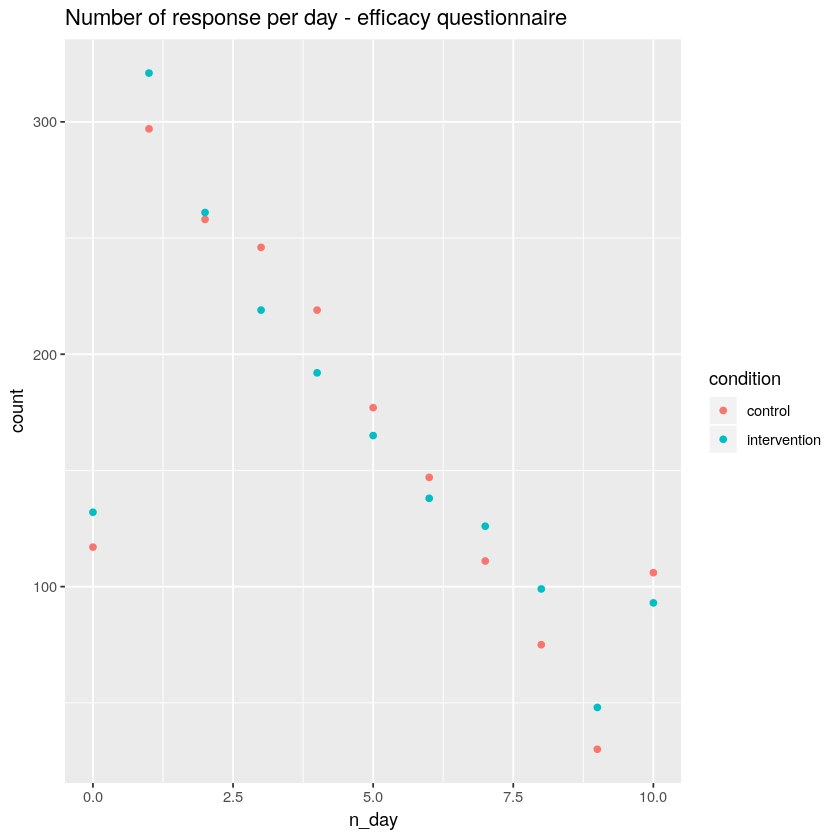

In [29]:
n_rep <- df %>% group_by(condition, n_day) %>%
 summarize(count=n())

n_rep <-n_rep %>% drop_na()


# plot
ggplot(data= n_rep, aes(x = n_day, y=count)) +
  geom_point(mapping = aes(colour = condition) ) +
  ggtitle("Number of response per day - efficacy questionnaire")
  ggsave('nresp_per_day.jpg', plot =last_plot(), dpi =300, path= save_figure)
 


- 3. Compute mean response and self efficacy score for each day for each pp

- 4. plot
!!! different number of data points per paricipant !!!

In [30]:
# compute total score for each measure for each day and each participant

df <- df %>% group_by(ID, n_day) %>% 
  mutate(total_re= sum(r_eff1, r_eff2), 
         total_se= sum(s_eff1, s_eff2, s_eff3)
         )

In [85]:
library(gmodels)

ERROR: Error in library(gmodels): there is no package called ‘gmodels’


In [107]:
# compute mean total of response and self efficacy score for each day for each condition
m_scores <- df %>% group_by(condition, n_day) %>% 
  summarise(mean_re= mean(total_re,na.rm=TRUE), 
            mean_se=mean(total_se, na.rm=TRUE), 
            mean_hope = mean(hope, na.rm=TRUE), 
           sd_re= sd(total_re,na.rm=TRUE), 
           sd_se=sd(total_se, na.rm=TRUE), 
            sd_hope = sd(hope, na.rm=TRUE), 
             n=n()       
           ) %>% 
   mutate(se_re = sd_re/sqrt(n), 
         se_se = sd_se/sqrt(n), 
         se_hope = sd_hope/sqrt(n), 
          ci_re = qt(1-(1-0.95/2),n-1)*se_re, 
         ci_se = qt(1-(1-0.95/2),n-1)*se_se, 
         ci_hope = qt(1-(1-0.95/2),n-1)*se_hope
         )

m_scores <- left_join(m_scores, n_rep)

Joining, by = c("condition", "n_day")



In [109]:
?qt

In [108]:
m_scores

condition,n_day,mean_re,mean_se,mean_hope,sd_re,sd_se,sd_hope,n,se_re,se_se,se_hope,ci_re,ci_se,ci_hope,count
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
control,0,366.9000,320.8500,31.50000,116.4456,214.5363,22.46919,117,10.765402,19.83389,2.077277,-0.6765258,-1.2464131,-0.13054150,117
control,1,395.5408,357.9091,39.25253,132.3117,226.9402,25.60722,297,7.677503,13.16841,1.485882,-0.4818399,-0.8264488,-0.09325390,297
control,2,410.8588,370.5698,38.88372,139.0273,208.7151,24.20362,258,8.655459,12.99403,1.506852,-0.5432863,-0.8156100,-0.09458213,258
control,3,401.7073,381.2561,40.10976,141.4851,232.8940,25.30484,246,9.020763,14.84878,1.613378,-0.5662428,-0.9320736,-0.10127340,246
control,4,405.4521,385.5616,42.13699,139.3907,235.6709,24.65746,219,9.419149,15.92516,1.666197,-0.5913249,-0.9997660,-0.10460219,219
control,5,382.8305,355.3966,39.23729,138.4691,224.2153,24.25246,177,10.407974,16.85305,1.822927,-0.6535819,-1.0583089,-0.11447299,177
control,6,395.3265,374.2653,40.93878,130.8135,208.7831,23.50815,147,10.789318,17.22014,1.938920,-0.6777274,-1.0816776,-0.12179260,147
control,7,387.6486,373.2973,38.81081,149.9260,244.1423,25.42887,111,14.230348,23.17296,2.413602,-0.8943776,-1.4564211,-0.15169491,111
control,8,396.9600,344.6400,37.16000,145.2883,264.9478,28.08724,75,16.776447,30.59353,3.243235,-1.0555710,-1.9249394,-0.20406375,75


Plot response and self efficacy scores

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



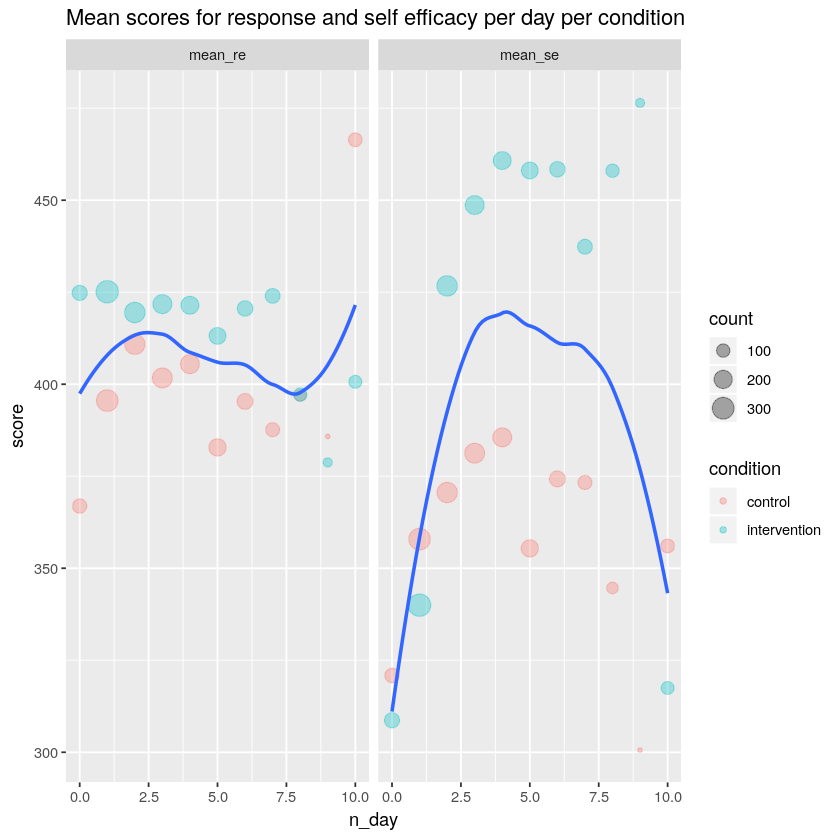

In [33]:
m_scores %>% gather("type", "score", 3:4 ) %>% 
  ggplot(data=., mapping=aes(x= n_day, y=score)) +
         geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+
        facet_wrap(~type)+
  geom_smooth(se=FALSE)+
  ggtitle("Mean scores for response and self efficacy per day per condition")
  
  ggsave('efficacy_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)


In [34]:
m_scores

condition,n_day,mean_re,mean_se,mean_hope,sd_re,sd_se,sd_hope,count
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
control,0,366.9000,320.8500,31.50000,116.4456,214.5363,22.46919,117
control,1,395.5408,357.9091,39.25253,132.3117,226.9402,25.60722,297
control,2,410.8588,370.5698,38.88372,139.0273,208.7151,24.20362,258
control,3,401.7073,381.2561,40.10976,141.4851,232.8940,25.30484,246
control,4,405.4521,385.5616,42.13699,139.3907,235.6709,24.65746,219
control,5,382.8305,355.3966,39.23729,138.4691,224.2153,24.25246,177
control,6,395.3265,374.2653,40.93878,130.8135,208.7831,23.50815,147
control,7,387.6486,373.2973,38.81081,149.9260,244.1423,25.42887,111
control,8,396.9600,344.6400,37.16000,145.2883,264.9478,28.08724,75


Plot hope score

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Saving 6.67 x 6.67 in image

`geom_smooth()` using method = 'loess' and formula 'y ~ x'



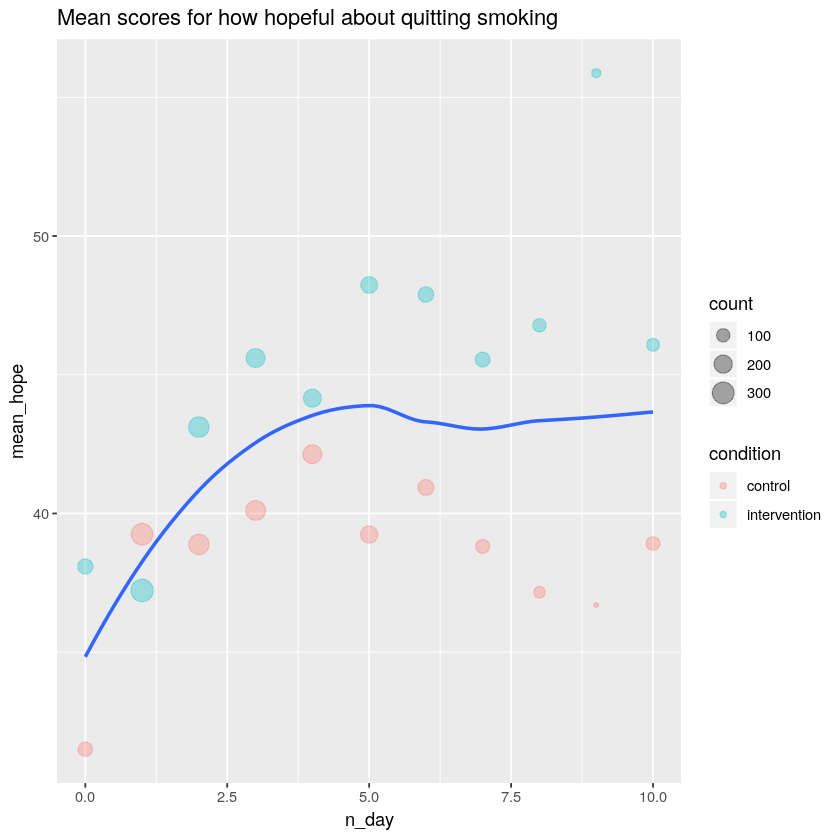

In [35]:

ggplot(data=m_scores, mapping=aes(x= n_day, y=mean_hope)) +
       geom_point(mapping = aes(colour=condition, size=count), alpha=1/3)+
      geom_smooth(se=FALSE)+
ggtitle("Mean scores for how hopeful about quitting smoking")

  ggsave('hope_scores.jpg', plot =last_plot(), dpi =300, path= save_figure)


Make raincloud plots

In [64]:
library(cowplot)
library(readr)
library(dplyr)

In [68]:
### This script creates an R function to generate raincloud plots, then simulates
### data for plots. If using for your own data, you only need lines 1-80.
### It relies largely on code previously written by David Robinson
### (https://gist.github.com/dgrtwo/eb7750e74997891d7c20)
### and the package ggplot2 by Hadley Wickham

# Check if required packages are installed ----
packages <- c("cowplot", "readr", "ggplot2", "dplyr", "lavaan", "smooth", "Hmisc")
if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
  install.packages(setdiff(packages, rownames(installed.packages())))
}

# Load packages ----
#library(ggplot2)

# Defining the geom_flat_violin function ----
# Note: the below code modifies the
# existing github page by removing a parenthesis in line 50

"%||%" <- function(a, b) {
  if (!is.null(a)) a else b
}

geom_flat_violin <- function(mapping = NULL, data = NULL, stat = "ydensity",
                             position = "dodge", trim = TRUE, scale = "area",
                             show.legend = NA, inherit.aes = TRUE, ...) {
  layer(
    data = data,
    mapping = mapping,
    stat = stat,
    geom = GeomFlatViolin,
    position = position,
    show.legend = show.legend,
    inherit.aes = inherit.aes,
    params = list(
      trim = trim,
      scale = scale,
      ...
    )
  )
}

#' @rdname ggplot2-ggproto
#' @format NULL
#' @usage NULL
#' @export
GeomFlatViolin <-
  ggproto("GeomFlatViolin", Geom,
    setup_data = function(data, params) {
      data$width <- data$width %||%
        params$width %||% (resolution(data$x, FALSE) * 0.9)

      # ymin, ymax, xmin, and xmax define the bounding rectangle for each group
      data %>%
        group_by(group) %>%
        mutate(
          ymin = min(y),
          ymax = max(y),
          xmin = x,
          xmax = x + width / 2
        )
    },

    draw_group = function(data, panel_scales, coord) {
      # Find the points for the line to go all the way around
      data <- transform(data,
        xminv = x,
        xmaxv = x + violinwidth * (xmax - x)
      )

      # Make sure it's sorted properly to draw the outline
      newdata <- rbind(
        plyr::arrange(transform(data, x = xminv), y),
        plyr::arrange(transform(data, x = xmaxv), -y)
      )

      # Close the polygon: set first and last point the same
      # Needed for coord_polar and such
      newdata <- rbind(newdata, newdata[1, ])
  ggplot2:::ggname("geom_flat_violin", GeomPolygon$draw_panel(newdata, panel_scales, coord))
    }, 
          
    draw_key = draw_key_polygon,

    default_aes = aes(
      weight = 1, colour = "grey20", fill = "white", size = 0.5,
      alpha = NA, linetype = "solid"
    ),

    required_aes = c("x", "y")
  )

Installing packages into ‘/home/claire/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

also installing the dependencies ‘xts’, ‘TTR’, ‘RcppParallel’, ‘quadprog’, ‘quantmod’, ‘lamW’, ‘statmod’, ‘fracdiff’, ‘lmtest’, ‘timeDate’, ‘tseries’, ‘urca’, ‘png’, ‘jpeg’, ‘checkmate’, ‘greybox’, ‘forecast’, ‘nloptr’, ‘zoo’, ‘RcppArmadillo’, ‘survival’, ‘Formula’, ‘latticeExtra’, ‘acepack’, ‘gridExtra’, ‘data.table’, ‘htmlTable’, ‘viridis’




In [37]:
colnames(df)

[1] "ID"                       "Starting Date"           
 [3] "condition"                "EEG"                     
 [5] "Finished"                 "removed"                 
 [7] "Interview"                "Notes"                   
 [9] "No Compliance"            "Email reminder poor perf"
[11] "date"                     "r_eff1"                  
[13] "r_eff2"                   "s_eff1"                  
[15] "s_eff2"                   "s_eff3"                  
[17] "hope"                     "type"                    
[19] "completed"                "n_day"                   
[21] "total_re"                 "total_se"

In [79]:
# compute mean total of response and self efficacy score for each day for each condition
df <- df %>% group_by(condition, n_day) %>% 
      mutate(mean_re= mean(total_re,na.rm=TRUE)) %>% 
            mutate(mean_se=mean(total_se, na.rm=TRUE)) %>%  
            mutate(mean_hope = mean(hope, na.rm=TRUE)) %>%  
           mutate(sd_re= sd(total_re,na.rm=TRUE)) %>%  
           mutate(sd_se=sd(total_se, na.rm=TRUE)) %>% 
            mutate(sd_hope = sd(hope, na.rm=TRUE))
           
         

In [46]:
colnames(test)

[1] "ID"                       "Starting Date"           
 [3] "condition"                "EEG"                     
 [5] "Finished"                 "removed"                 
 [7] "Interview"                "Notes"                   
 [9] "No Compliance"            "Email reminder poor perf"
[11] "date"                     "r_eff1"                  
[13] "r_eff2"                   "s_eff1"                  
[15] "s_eff2"                   "s_eff3"                  
[17] "hope"                     "type"                    
[19] "completed"                "n_day"                   
[21] "total_re"                 "total_se"                
[23] "mean_re"                  "mean_se"                 
[25] "mean_hope"                "sd_re"                   
[27] "sd_se"                    "sd_hope"

In [51]:
packages <- c("ggplot2", "dplyr", "lavaan", "plyr", "cowplot", "rmarkdown",
"readr", "caTools", "bitops")
if (length(setdiff(packages, rownames(installed.packages()))) > 0) {
install.packages(setdiff(packages, rownames(installed.packages())))
}

Installing package into ‘/home/claire/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

also installing the dependencies ‘mnormt’, ‘pbivnorm’, ‘numDeriv’




In [58]:
library(ggplot2)

In [60]:
install.packages("ggplot2")
install.packages("dplyr")
install.packages("lavaan")
install.packages("plyr")
install.packages("cowplot")
install.packages("rmarkdown")
install.packages("readr")
install.packages("caTools")
install.packages("bitops")

Installing package into ‘/home/claire/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/claire/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/claire/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/claire/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/claire/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/claire/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/claire/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/claire/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)

Installing package into ‘/home/claire/R/x86_64-pc-linux-gnu-library/3.6’
(as ‘lib’ is unspecified)



In [72]:
fig<-ggplot(df, aes(x=condition, y=total_se, fill=condition))+
    geom_flat_violin(position=position_nudge(x = .2, y = 0),adjust = .2)+
    geom_point(position = position_jitter(width = .15), size = .25)+
    ylab('Score')+xlab('Group')+coord_flip()+theme_cowplot()+guides(fill = FALSE)+
    ggtitle('Total efficacy score')

Warning message:
“Removed 192 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 192 rows containing missing values (geom_point).”


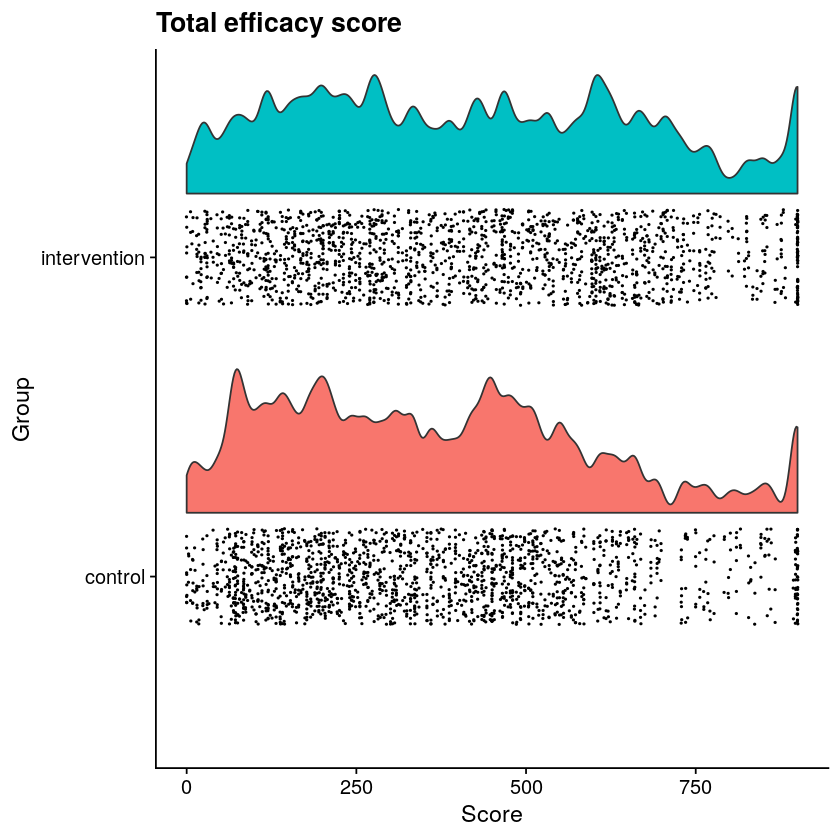

In [73]:
fig

Warning message:
“Ignoring unknown aesthetics: y”
Warning message:
“Removed 192 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 192 rows containing missing values (geom_point).”


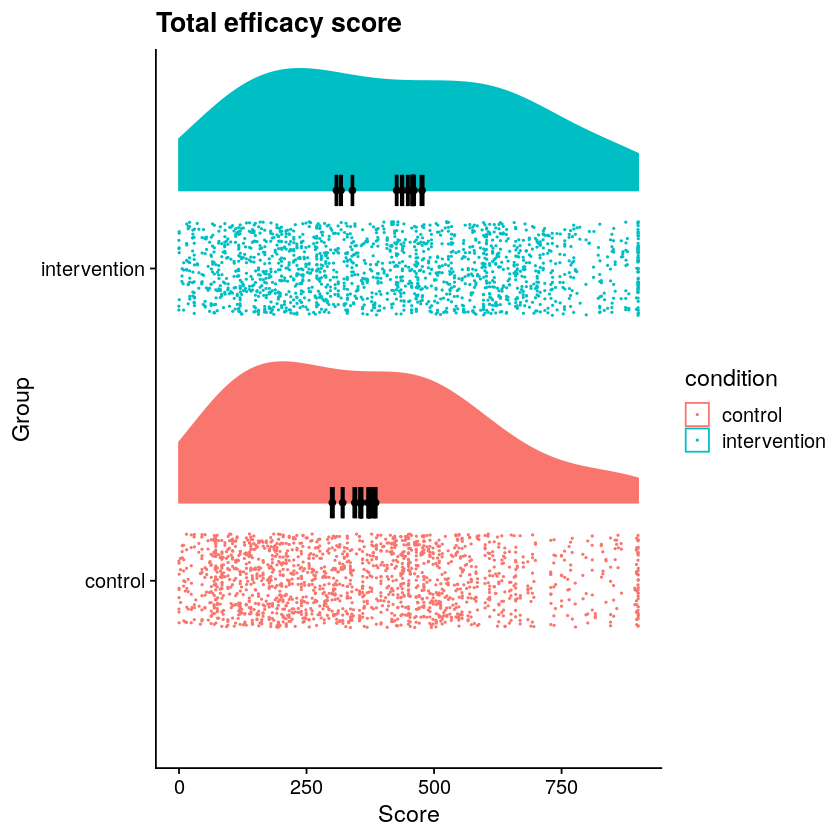

In [110]:
ggplot(df, aes(x=condition, y=total_se, fill=condition, colour=condition))+
    geom_flat_violin(position=position_nudge(x = .25, y = 0),adjust = 2)+
    geom_point(position = position_jitter(width = .15), size = .25)+
    geom_point(data=m_scores, aes(x=condition, y=mean_se), position = position_nudge(.25), colour = "BLACK")+
    geom_errorbar(data =m_scores, aes(x = condition, y = mean_se, ymin = mean_se-ci_se, ymax = mean_se+ci_se), position = position_nudge(.25), colour = "BLACK", width = 0.1, size = 0.8)+
    
ylab('Score')+xlab('Group')+coord_flip()+theme_cowplot()+guides(fill = FALSE)+
    ggtitle('Total efficacy score')

Warning message:
“Ignoring unknown aesthetics: y”
Warning message:
“Removed 192 rows containing non-finite values (stat_ydensity).”
Warning message:
“Removed 192 rows containing non-finite values (stat_boxplot).”
Warning message:
“Removed 192 rows containing missing values (geom_point).”


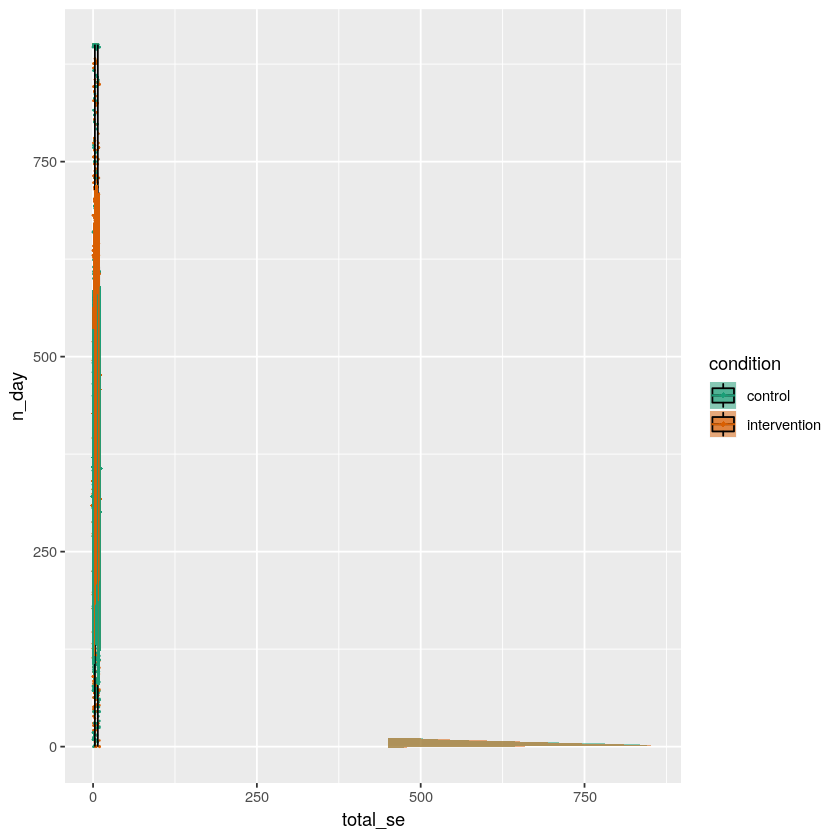

In [81]:
ggplot(df, aes(x = total_se, y = n_day , fill = condition)) +
  geom_flat_violin(aes(fill = condition),position = position_nudge(x = .1, y = 0), adjust = 1.5, trim = FALSE, alpha = .5, colour = NA)+
  geom_point(aes(x = as.numeric(n_day)-.15, y = total_se, colour = condition),position = position_jitter(width = .05), size = .25, shape = 20)+
  geom_boxplot(aes(x = n_day, y = total_se, fill = condition),outlier.shape = NA, alpha = .5, width = .1, colour = "black")+
  geom_line(data = df, aes(x = as.numeric(n_day)+.1, y = mean_se, group = condition, colour = condition), linetype = 3)+
  geom_point(data = df, aes(x = as.numeric(n_day)+.1, y = mean_se, group = condition, colour = condition), shape = 18) +
  geom_errorbar(data = df, aes(x = as.numeric(n_day)+.1, y = mean_se, group = condition, colour = condition, ymin = mean_se-sd_se, ymax = mean_se+sd_se), width = .05)+
  scale_colour_brewer(palette = "Dark2")+
  scale_fill_brewer(palette = "Dark2")
  

In [ ]:
ggplot(df, aes(x = n_day, y = total_se , fill = condition)) +
  geom_flat_violin(aes(fill = condition),position = position_nudge(x = .1, y = 0), adjust = 1.5, trim = FALSE, alpha = .5, colour = NA)+
  geom_point(aes(x = as.numeric(n_day)-.15, y = total_se, colour = condition),position = position_jitter(width = .05), size = .25, shape = 20)+
  geom_boxplot(aes(x = n_day, y = total_se, fill = condition),outlier.shape = NA, alpha = .5, width = .1, colour = "black")+
  geom_line(data = df, aes(x = as.numeric(n_day)+.1, y = mean_se, group = condition, colour = condition), linetype = 3)+
  geom_point(data = df, aes(x = as.numeric(n_day)+.1, y = mean_se, group = condition, colour = condition), shape = 18) +
  geom_errorbar(data = df, aes(x = as.numeric(n_day)+.1, y = mean_se, group = condition, colour = condition, ymin = mean_se-sd_se, ymax = mean_se+sd_se), width = .05)+
  scale_colour_brewer(palette = "Dark2")+
  scale_fill_brewer(palette = "Dark2")